Results from SCARGC algorithm (for boxplot and accuracy timelime).
Electricity data. 7 features. 2 classes.
Stream mode with pool size = 300



METHOD: Static knn as classifier
Execution time:  11.155212185595186
Average MCC:  0.340860145984
Average micro-F1: 0.7069000000000001


C:\Users\raul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


Average Accuracy:  69.9504
Standard Deviation:  11.8032169276
Variance:  139.31592984


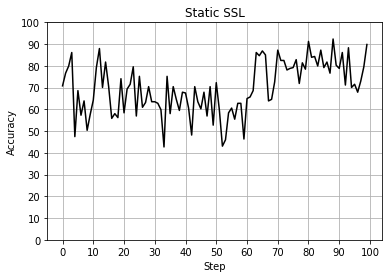

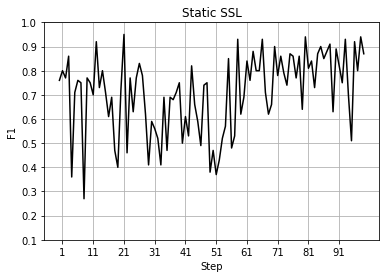




METHOD: Sliding knn as classifier


C:\Users\raul\Desktop\GITHUB\Systems-Engineering\Dissertation\source\classifiers.py:135: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return KNeighborsClassifier(n_neighbors=K, algorithm = 'brute').fit(X, y)


Execution time:  11.507391404487349
Average MCC:  0.0276522880073
Average micro-F1: 0.5998
Average Accuracy:  59.0542
Standard Deviation:  9.03869240322
Variance:  81.69796036


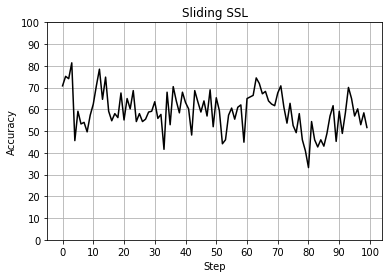

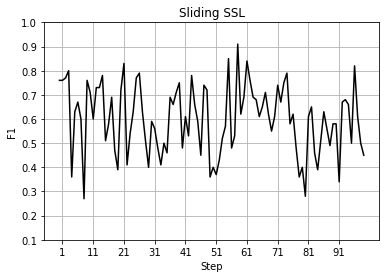




METHOD: Incremental knn as classifier
Execution time:  256.2526181718052
Average MCC:  0.213344355374
Average micro-F1: 0.6477999999999998
Average Accuracy:  64.1554
Standard Deviation:  10.0504118741
Variance:  101.01077884


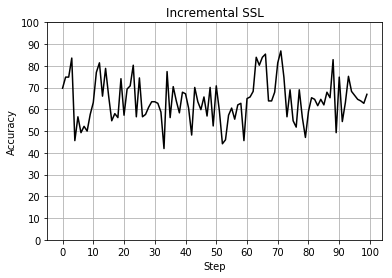

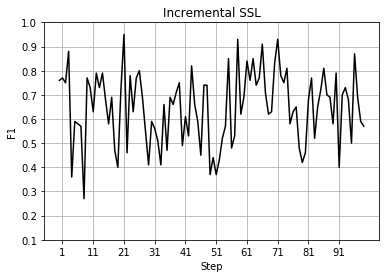




METHOD: knn as classifier and kde as core support extraction with cutting data method
Execution time:  125.03260996242568
Average MCC:  0.378126140708
Average micro-F1: 0.6886000000000001
Average Accuracy:  67.7426
Standard Deviation:  11.4153763512
Variance:  130.31081724


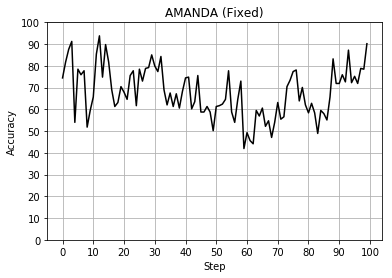

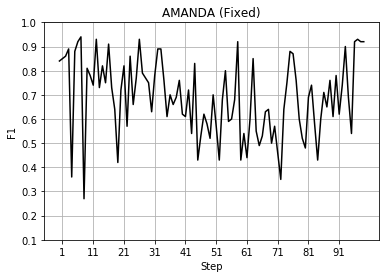




METHOD: knn as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  1780.0462443274096
Average MCC:  0.398872606579
Average micro-F1: 0.7247999999999999
Average Accuracy:  71.5824
Standard Deviation:  12.1885352787
Variance:  148.56039224


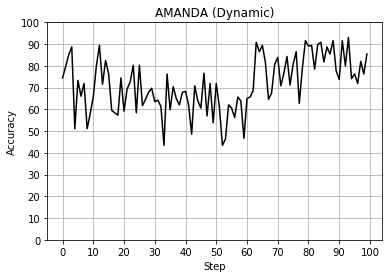

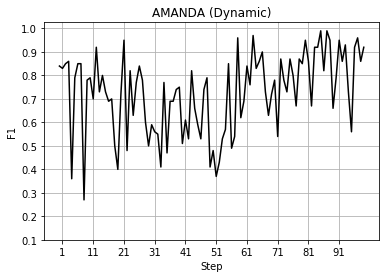




Method: SCARGC
Execution time:  1780.0462443274096
Average MCC:  -0.00131563669883
Average micro-F1: 0.46389999999999987
Average Accuracy:  61.7116205534
Standard Deviation:  2.22199808664
Variance:  4.93727549702


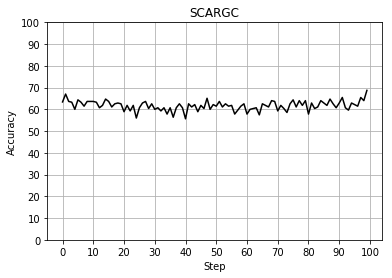

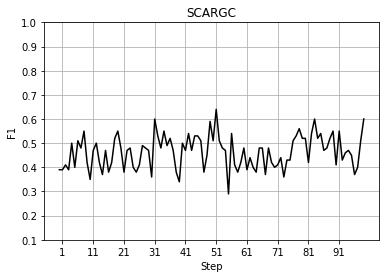

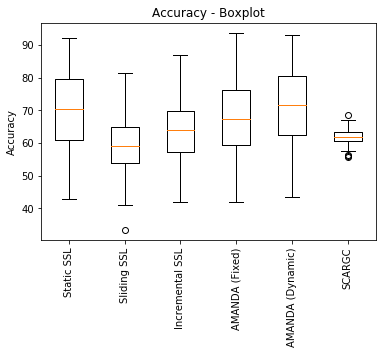

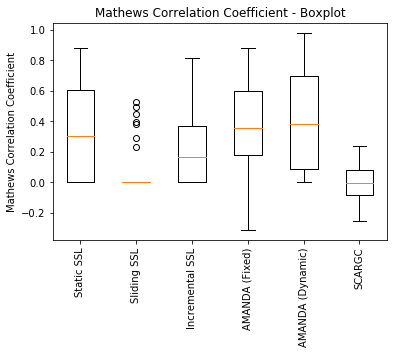

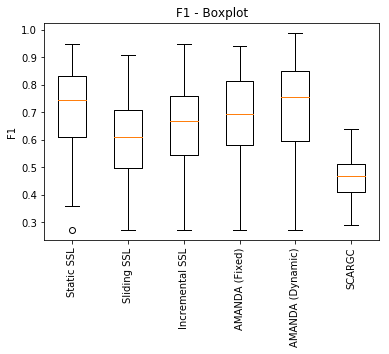

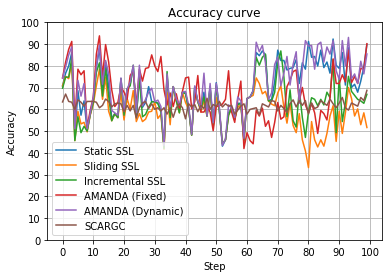

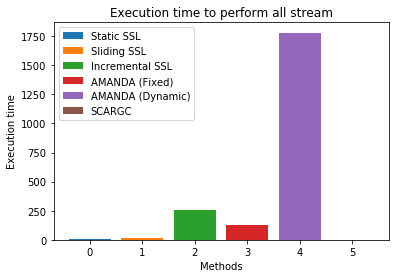

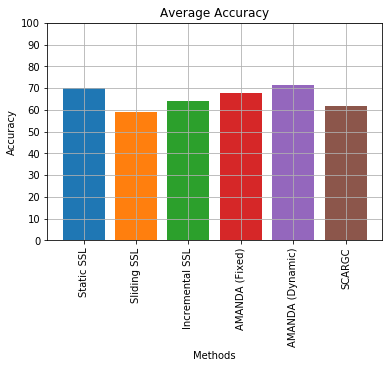

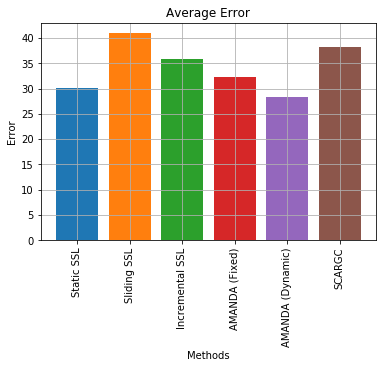

Error reduction: -15.5770374437
Error reduction: -8.28444154715
Error reduction: -3.15623641895
Error reduction: 2.33308172648
Error reduction: -11.7780304997


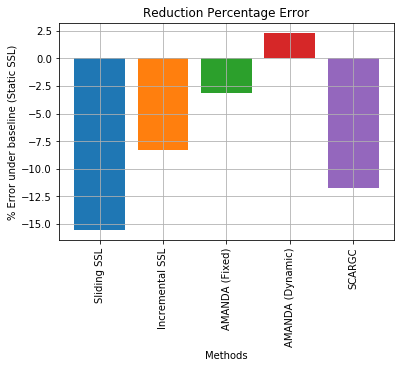

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import scargc_1NN
import numpy as np


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
    
        
def accSCARGC(path, sep, key, steps):
    resultsSCARGC_1, resultsSCARGC_2 = setup.loadSCARGCBoxplotResults(path, sep)
    results = resultsSCARGC_1[key]
    res = [ results[i::steps] for i in range(steps) ]
    
    arrAcc = []
    for i in range(steps):
        arrAcc.append(sum(res[i])/len(res[i])*100)
        #print(len(res[i]))
    
    return arrAcc, results


#only for binary classification
def labelSCARGC(resultsSCARGC, true_labels):
    predictions = []
    true_labels = np.array(true_labels)
    true_labels = true_labels.flatten()
    #print(true_labels)
    for i in range(len(true_labels)):
        if resultsSCARGC[i] == 1:
            predictions.append(true_labels[i])
        else:
            if true_labels[i] == 0:
                predictions.append(1)
            else:
                predictions.append(0)
    return predictions


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    sslClassifier = 'knn' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    labeledData = 150
    poolSize = 300
    isBatchMode = False # False = Stream
    isBinaryClassification = True
    isImbalanced = True
    externalResults = []
    
    #real
    dataValues, dataLabels, description = setup.loadElecData(path, sep)
    

    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 9, 0.75, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 9, None, "kde", sslClassifier)

    # SCARGC 1NN (Python version)
    #experiments[5] = Experiment(scargc_1NN, 2)
    
    arrAccSCARGC, predictionsSCARGC = accSCARGC(path, sep, 'elec2', steps)
    #predictionsSCARGC = labelSCARGC(predictionsSCARGC, dataLabels[labeledData:])
    arrPredictionsSCARGC = [ predictionsSCARGC[i::steps] for i in range(steps) ]
    externalResults.append({"name":"SCARGC", "predictions":arrPredictionsSCARGC, "accuracies":arrAccSCARGC, "time":0})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)


if __name__ == "__main__":
    main()